In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
from tqdm import tqdm
from python_speech_features import mfcc, logfbank

In [2]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(20,5))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(20,5))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i], cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size=16)
    i = 0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i], cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1


In [3]:
AUDIO_FOLDER = 'wavfiles/'

In [4]:
# Create an empty DataFrame
df = pd.DataFrame()

# Iterate through instruments in the AUDIO_FOLDER
for instrument in os.listdir(path=AUDIO_FOLDER):
    audio_list = os.listdir(path=f'{AUDIO_FOLDER}{instrument}/')
    
    # Create a temporary DataFrame for each instrument
    temp = pd.DataFrame(audio_list, columns=['Filename'])
    temp['Instrument'] = instrument
    
    # Concatenate the temporary DataFrame with the main DataFrame
    df = pd.concat([df, temp])

# Set 'Filename' as the index of the DataFrame
df.set_index('Filename', inplace=True)

# Iterate through filenames in the DataFrame index
for f in df.index:
    # Read the WAV file and calculate its length
    rate, signal = wavfile.read(f'wavfiles/{df.at[f, "Instrument"]}/{f}')
    df.at[f, 'Length'] = signal.shape[0] / rate

In [116]:
df.to_csv('instuments.csv', encoding='utf-8', index=False)

In [101]:
# Extract unique classes from the 'Instrument' column in DataFrame df
classes = list(np.unique(df['Instrument']))

# Calculate the mean length of audio for each class and store it in class_dist
class_dist = df.groupby(['Instrument'])['Length'].mean()

# Reset Indexes in dataFrame
df.reset_index(inplace=True)

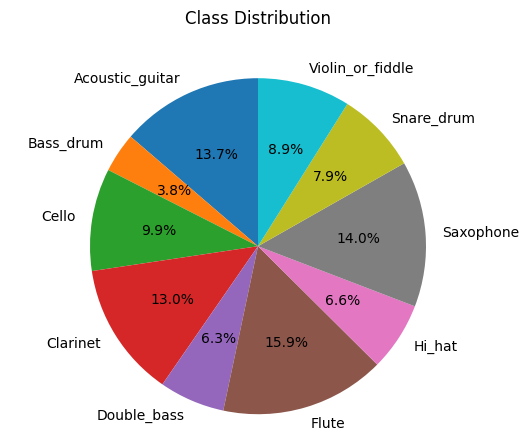

In [6]:
fix, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=classes, startangle=90, autopct='%1.1f%%')
ax.axis('equal')
plt.show()

In [30]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10), min_periods=1, center=True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [7]:
def calc_fft(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [8]:
signals = {}
fft = {}
fbank = {}
mfccs = {}

In [120]:
for c in classes:
    wav_file = df[df.Instrument == c].iloc[0,0]
    signal, rate = librosa.load(f'wavfiles/{c}/{wav_file}', sr=44100)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)

    bank = logfbank(signal[:rate], rate, nfilt=26, nfft=1103).T # nfft = 44100 / 40 = 1102.5
    fbank[c] = bank

    mel = mfcc(signal[:rate], rate, numcep=13, nfilt=26, nfft=1103).T
    mfccs[c] = mel

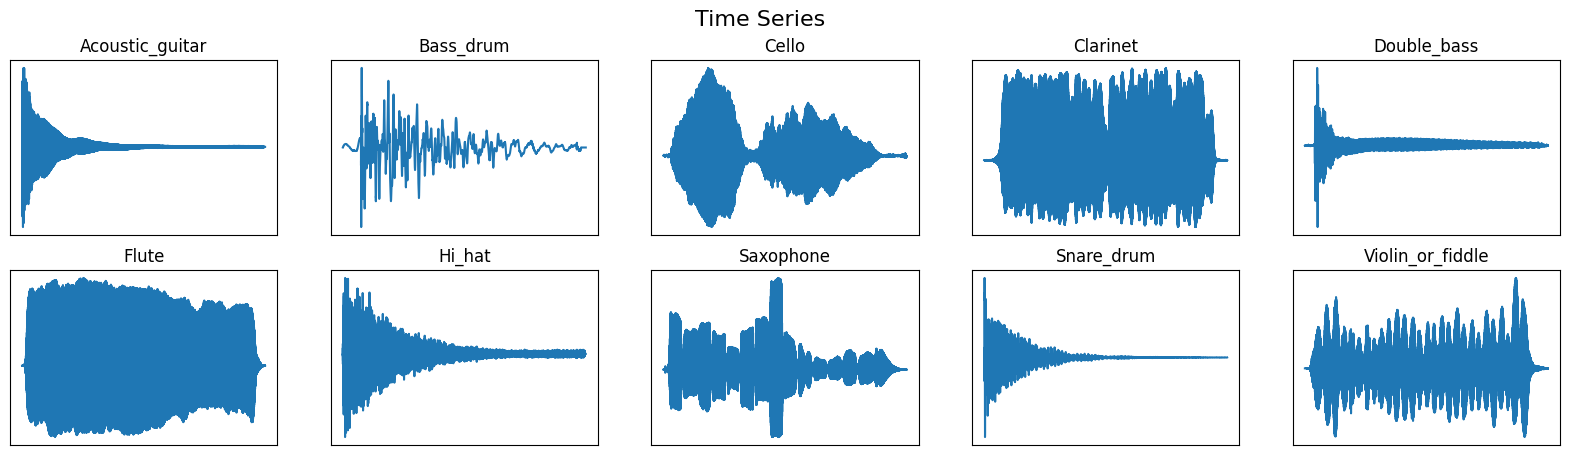

In [55]:
plot_signals(signals)
plt.show()

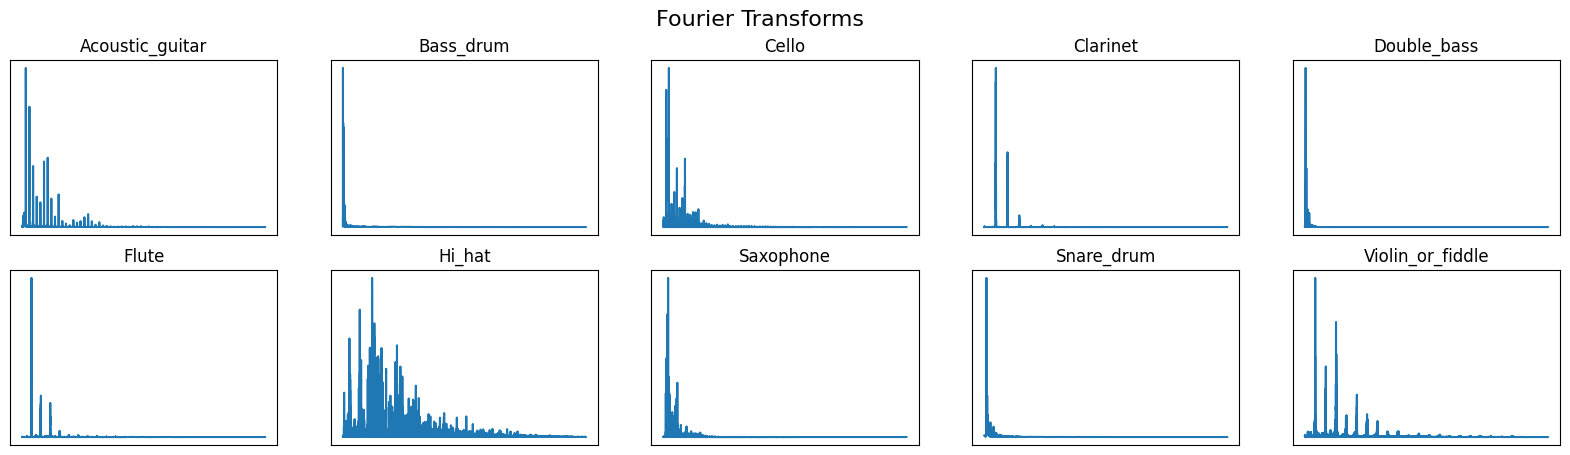

In [56]:
plot_fft(fft)
plt.show()

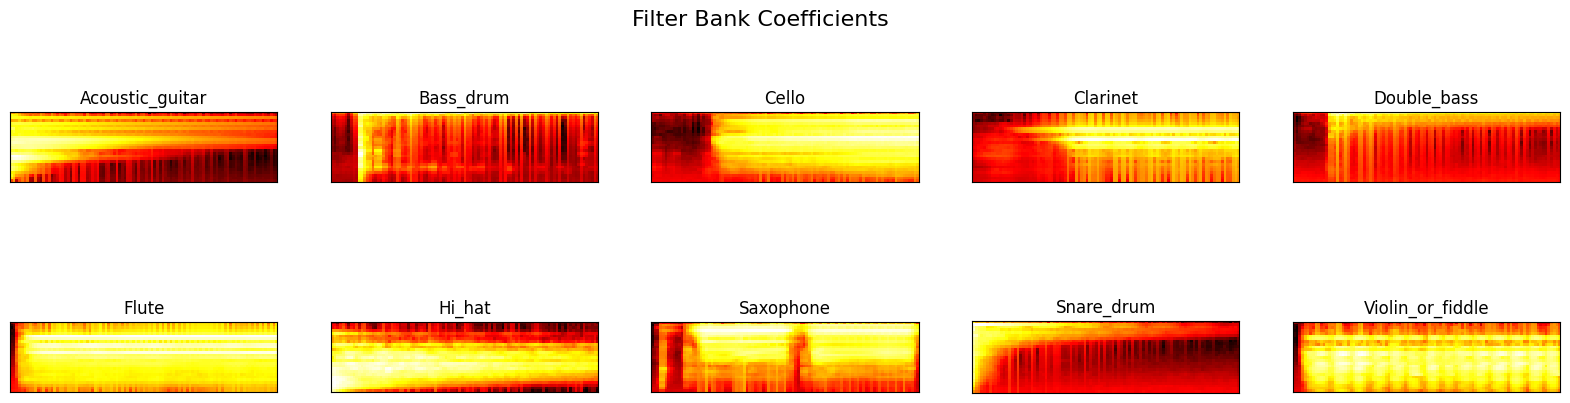

In [57]:
plot_fbank(fbank)
plt.show()

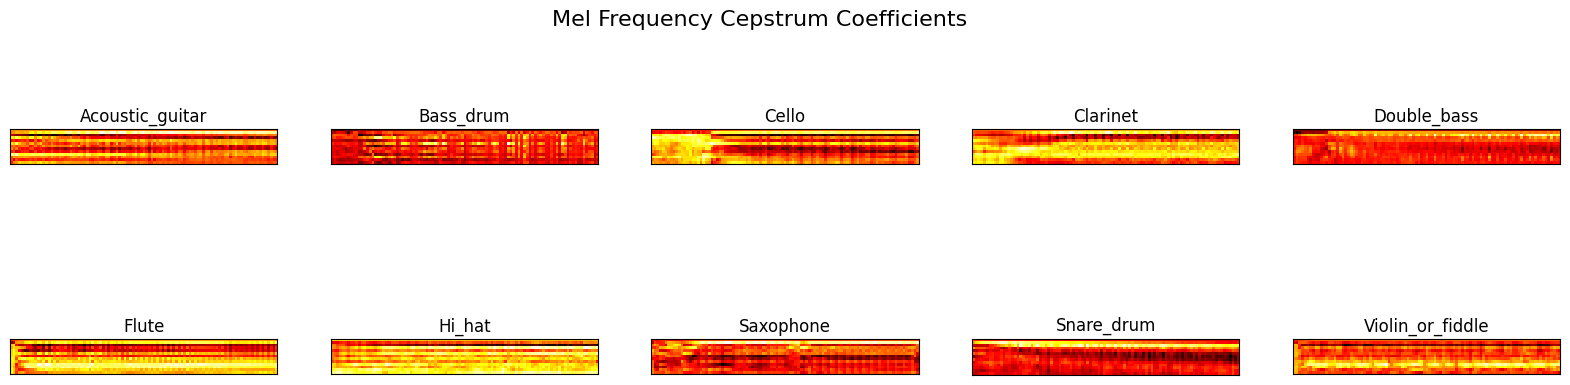

In [121]:
plot_mfccs(mfccs)
plt.show()

In [122]:
if len(os.listdir('clean')) == 0:
    for i in tqdm(df.index):
        record = df.iloc[i]
        path = f'{AUDIO_FOLDER}{record.Instrument}/{record.Filename}'
        signal, rate = librosa.load(path, sr=16000)
        mask = envelope(signal, rate, 0.0005)
        wavfile.write(filename=f'clean/{record.Filename}', rate=rate, data=signal[mask])